<a href="https://colab.research.google.com/github/ngocanh1018/Thesis/blob/master/1908_Tweeter_Data_bert_uncased_balanced_5_fold_CV_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweeter Data

In [ ]:
!pip install GetOldTweets3


In [ ]:
import GetOldTweets3 as got


In [ ]:
def get_tweets(query, start_date, end_date):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria()\
                          .setQuerySearch(query)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                              
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.mentions,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    news_df = pd.DataFrame(text_tweets, 
                            columns = ['Text','Date','Favorites', 'Retweets', 'Mentions', 'HashTags'])
    
    return news_df

Downloadn tweets that contains 3 words "DJI","stock" and "market" from 01-03-2020 to 31-05-2020

In [ ]:
df= get_tweets('DJI stock market', '2020-03-01', '2020-06-01')

Save the collected data to a csv file

In [ ]:
df.to_csv('tweet_data.csv')

# Stock Data

In [ ]:
import pandas as pd
from pandas_datareader import data

start_date = '2020-02-28'
end_date = '2020-06-01'

ticker = '^DJI'

#download data of Down Jones Industrial Index from 28-02-2020 to 31-05.2020
data = data.get_data_yahoo(ticker, start_date, end_date)

#save the output to an csv file
data.to_csv('DJI_data.csv')

# Environment Setup

In [8]:
pip install transformers[torch]

     |████████████████████████████████| 778kB 3.3MB/s 
     |████████████████████████████████| 890kB 9.0MB/s 
     |████████████████████████████████| 1.1MB 15.3MB/s 
     |████████████████████████████████| 3.0MB 24.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fd635ad2e0436b1f84047063cbb412b08c381c43612e5f3633ac4b790adf4fa1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [9]:
!pip install -q -U watermark

In [10]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.6.0+cu101
transformers 3.0.2


In [11]:
import transformers
from transformers import BertModel, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Exploration

In [12]:
#Download tweet data after labelling from Github repository  
url="https://raw.githubusercontent.com/ngocanh1018/Thesis/master/data1808_balanced_135.csv"

df=pd.read_csv(url)

In [13]:
df.shape

(405, 8)

In [14]:
df.head(5)

,Unnamed: 0,Text,Sentiment,Date,Favorites,Retweets,Mentions,HashTags
0,0,#Unemployment at its highest while the #billio...,negative,2020-05-31 22:51:49+00:00,0,4,NaN,#Unemployment #billionaires #bailouts #protest...
1,2,#global #Shutdown WAS #shutdown #FederalGovt m...,neutral,2020-05-31 20:53:14+00:00,1,0,NaN,#global #Shutdown #shutdown #FederalGovt #mone...
2,5,Does the stock market go up or down Monday? $S...,neutral,2020-05-31 00:51:18+00:00,1,0,NaN,#stocks #stockmarket
3,8,#Bullish H&amp;S on $XLNX It's ready for a bre...,positive,2020-05-30 05:10:53+00:00,2,0,NaN,#Bullish #StockMarket #Futures #options #beari...
4,9,The year is 2020! Wow! #COVID19 #BREAKING #Not...,positive,2020-05-30 00:01:24+00:00,1,2,NaN,#COVID19 #BREAKING #NotDyingForWallStreet #tog...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  405 non-null    int64 
 1   Text        405 non-null    object
 2   Sentiment   405 non-null    object
 3   Date        405 non-null    object
 4   Favorites   405 non-null    int64 
 5   Retweets    405 non-null    int64 
 6   Mentions    60 non-null     object
 7   HashTags    283 non-null    object
dtypes: int64(3), object(5)
memory usage: 25.4+ KB


Date column has the data type of object. We will convert it to datetime

In [16]:
df.Date = pd.to_datetime(df.Date)

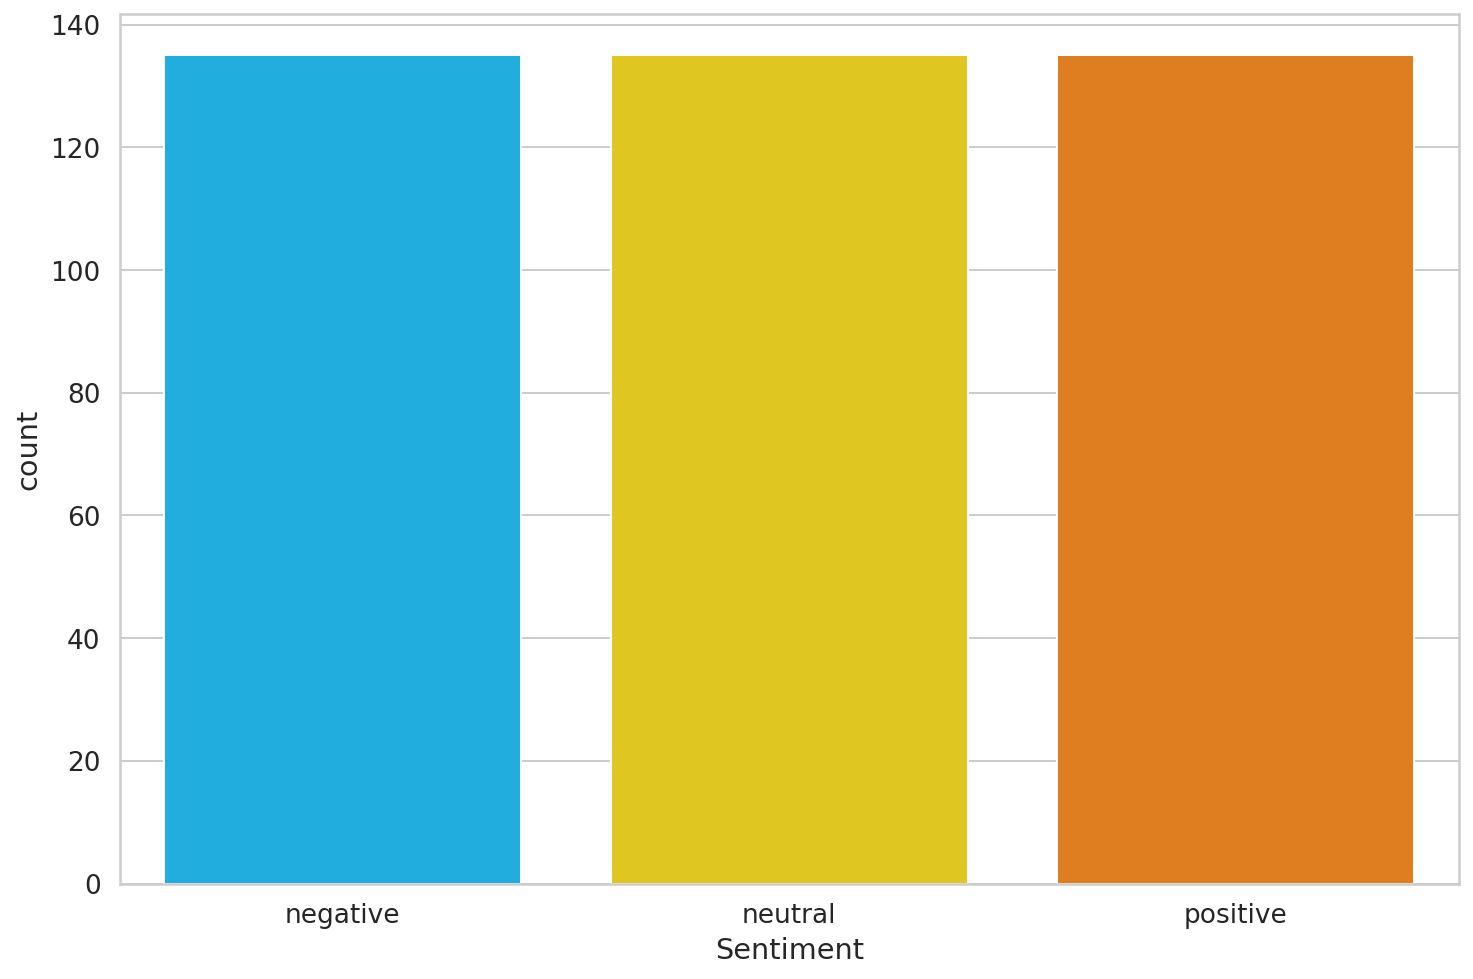

In [17]:
ax = sns.countplot(df.Sentiment)

In [18]:
def to_sentiment(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

df['senti'] = df.Sentiment.apply(to_sentiment)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Unnamed: 0  405 non-null    int64              
 1   Text        405 non-null    object             
 2   Sentiment   405 non-null    object             
 3   Date        405 non-null    datetime64[ns, UTC]
 4   Favorites   405 non-null    int64              
 5   Retweets    405 non-null    int64              
 6   Mentions    60 non-null     object             
 7   HashTags    283 non-null    object             
 8   senti       405 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(4)
memory usage: 28.6+ KB


# Pre-processing

## Clean Text
For the Text column, we replace all cashtags (e.g: $YHOO) by a common word “cashtag”, all urls (http / https) by a common word (linktag), all users (@howardlindzon, @ OpenOutcri-er...) by a common word usertag and all hashtag with blank space. 

In [14]:
import re
def process_tweet(tweet):
    tweet = re.sub(r'\$\w*','cashtag', str(tweet))
    tweet = re.sub(r'\@\w*','usertag', str(tweet))
    tweet = re.sub('#','', str(tweet))
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','linktag',str(tweet))
    tweet = " ".join(tweet.split())

    return tweet

In [15]:
df['Text']=df['Text'].apply(process_tweet)

To prepare data for BERT, the following requirement should be fullfiled: 

*   Add special tokens to separate sentences and do classification
*   Pass sequences of constant length (introduce padding)

*   Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch. It also includes prebuild tokenizers that support us in the heavy tokenizing tasks. 

The uncased version of BERT and Tokenizer will be loaded:

In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Special Token
* [SEP] - marker for ending of a sentence
* [CLS] - add this token to the start of each sentence, so BERT knows we’re doing classification
* [PAD] - a special token for padding
* [UNK] - BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token

All of that work can be done using the encode_plus() method:

In [22]:
sample_txt = 'Today is the best day ever in the stock market'

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation = True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2651, 2003, 1996, 2190, 2154, 2412, 1999, 1996, 4518, 3006,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [22]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'today',
 'is',
 'the',
 'best',
 'day',
 'ever',
 'in',
 'the',
 'stock',
 'market',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing Sequence Length

Let’s store the token length of each review and choose the maximum as sequence length.

In [26]:
token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

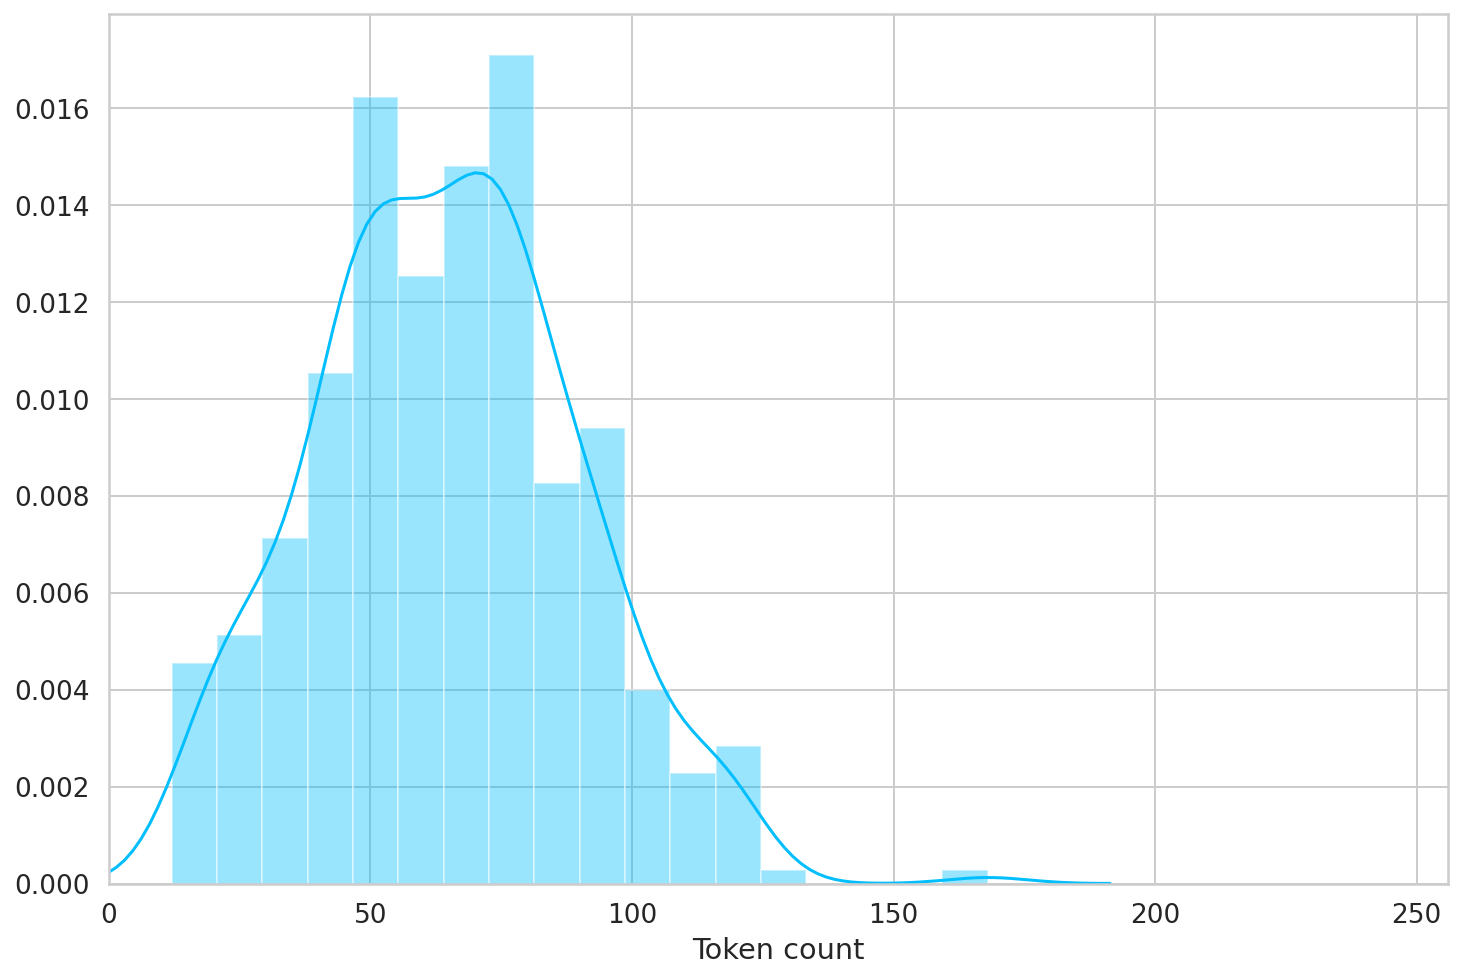

In [27]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 140 tokens, but we'll be on the safe side and choose a maximum length of 150.

In [25]:
MAX_LEN = 150

## Create PyTorch Dataset

In [28]:
class TweeterDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text   = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation = True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

## Create Data Loader

In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TweeterDataset(
    texts=df.Text.to_numpy(),
    targets=df.senti.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
    
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## Sentiment Classification with BERT and HuggingFace

We’ll use the basic BertModel and build our sentiment classifier on top of it

In [30]:
bert_model =  BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

We defined the sequence length of 32 tokens in the previous section. The number of hidden units in the feedforward-networks of BERT is 768

In [31]:
bert_model.config.hidden_size

768

### Create a Classifier using BERT model

In [32]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [33]:
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

### Training 

#### Optimizer and Scheduler

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it’s similar to the original paper. We’ll also use a linear scheduler with no warmup steps:

In [34]:
def OptimizerSchedulerLoss(model,train_data_loader,epochs):
  EPOCHS = epochs
  optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
  total_steps = len(train_data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
      )

  loss_fn = nn.CrossEntropyLoss().to(device)

  return optimizer, scheduler, loss_fn

#### Train Epoch

In [35]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

### Evaluation Model

In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

### Get Prediction

In [37]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return texts, predictions, prediction_probs, real_values


### Implement

In [36]:
%%time
BATCH_SIZE = 16
EPOCHS = 10
n=5

kf = KFold(n_splits=n, random_state=1, shuffle=True)

best_results = []
history = defaultdict(list)

k_fold = 1

for train_index, val_index in kf.split(df):  
  # splitting Dataframe (dataset not included)
    df_train = df.iloc[train_index]
    df_val = df.iloc[val_index]

  # create data loader
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

  # calcualte opimizer, scheduler, loss 
    optimizer, scheduler, loss_fn = OptimizerSchedulerLoss(
        model,
        train_data_loader,
        EPOCHS
        )
    
    print(f'Cross Validation: fold {k_fold}')

  # create training loop
    best_accuracy = 0
    best_prescision = 0
    best_fscore = 0
    best_recall = 0

    for epoch in range(EPOCHS):
      print(f'Epoch {epoch + 1}/{EPOCHS}')
      print('-' * 10)
      train_acc, train_loss = train_epoch(
          model,
          train_data_loader,    
          loss_fn, 
          optimizer, 
          device, 
          scheduler, 
          len(df_train)
          )

      print(f'Train loss {train_loss} accuracy {train_acc}')

      val_acc, val_loss = eval_model(
          model,
          val_data_loader,
          loss_fn, 
          device, 
          len(df_val)
          )
      
      print(f'Val   loss {val_loss} accuracy {val_acc}')

      y_texts, y_pred, y_pred_probs, y_test = get_predictions(
          model,
          val_data_loader
          )
       
      precision, recall, fscore, support = precision_recall_fscore_support(
          y_test, 
          y_pred, 
          average='macro')
      
      print(f'Precision {precision} Recall {recall} Fscore {fscore} Support {support}')
      print()

      history['train_acc'].append(train_acc)
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc)
      history['val_loss'].append(val_loss)
      history['precision'].append(precision)
      history['fscore'].append(fscore)
      history['recall'].append(recall)
      history['support'].append(support) 

      if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
        best_precision = precision
        best_fscore = fscore
        best_recall = recall
        best_support = support

    best_results.append([best_accuracy,best_precision,best_fscore,best_recall,best_support])
    k_fold += 1
    

Cross Validation: fold 1
Epoch 1/10
----------
Train loss 1.077476143836975 accuracy 0.4012345679012346
Val   loss 1.1188303232192993 accuracy 0.37037037037037035


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision 0.44298245614035087 Recall 0.38383838383838387 Fscore 0.25273579989577905 Support None

Epoch 2/10
----------
Train loss 1.0279338615281242 accuracy 0.46296296296296297
Val   loss 1.1905691822369893 accuracy 0.41975308641975306
Precision 0.25213675213675213 Recall 0.3466666666666667 Fscore 0.22200772200772198 Support None

Epoch 3/10
----------
Train loss 1.0805944034031458 accuracy 0.37037037037037035
Val   loss 1.2144728799661 accuracy 0.4691358024691358
Precision 0.32702020202020204 Recall 0.44202020202020204 Fscore 0.36640376366403765 Support None

Epoch 4/10
----------
Train loss 0.8638508234705243 accuracy 0.5462962962962963
Val   loss 0.9433294336001078 accuracy 0.49382716049382713
Precision 0.37762237762237766 Recall 0.4918752744839701 Fscore 0.39692887150514267 Support None

Epoch 5/10
----------
Train loss 0.6298186410041082 accuracy 0.6728395061728395
Val   loss 0.993694672981898 accuracy 0.6666666666666666
Precision 0.6723076923076924 Recall 0.6695125164690383 Fsc

In [45]:
best_results_df = pd.DataFrame(best_results, columns = ['Accuracy', 'Precision', 'FScore','Recall', 'Support'])

In [ ]:
best_results_df

In [54]:
 best_results_df.Precision.mean(),  best_results_df.Precision.std()

(0.9236146076146078, 0.14149920876935113)

In [55]:
 best_results_df.FScore.mean(),  best_results_df.FScore.std()

(0.9224518506028337, 0.1456006113042864)

In [56]:
 best_results_df.Recall.mean(),  best_results_df.Recall.std()

(0.9245220629456254, 0.14337470925279003)

In [43]:
accuracy_list = [0.6667, 0.9630, 0.9877, 1, 1]
np.mean(accuracy_list), np.std(accuracy_list)

(0.92348, 0.1290988985235738)

In [64]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [80]:
text = 'bearish market'

In [81]:
MAX_LEN = 150
encoded_text = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  truncation = True, 
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [82]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Text       : {text}')
print(f'Sentiment  : {class_names[prediction]}')


Text       : bearish market
Sentiment  : negative
